# Intro

In [9]:
df = pd.read_csv('uk_macro_q.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,London HPI,employment rate,100/mortgage rate,Real_FTSE100,Real GDP PC CHG
Date,,,,,
1995-06-30,18.658309,65.333333,12.274212,49.259713,0.862432
1995-09-30,18.737812,64.633333,12.568520,52.090428,1.313869
1995-12-31,18.501414,64.666667,12.515645,53.965645,0.288184
1996-03-31,18.792822,64.966667,15.123763,55.095228,0.841544
1996-06-30,19.206689,65.633333,14.511794,54.855619,0.040708


In [10]:
import random

random.seed(1)
ss = StandardScaler().fit_transform(df)
ss = pd.DataFrame(ss, index=df.index, columns=df.columns)
ss.head()

,London HPI,employment rate,100/mortgage rate,Real_FTSE100,Real GDP PC CHG
Date,,,,,
1995-06-30,-1.503143,-1.726656,-0.999380,-1.734435,0.730367
1995-09-30,-1.500657,-2.035014,-0.982728,-1.446674,1.330370
1995-12-31,-1.508047,-2.020330,-0.985720,-1.256047,-0.032862
1996-03-31,-1.498938,-1.888177,-0.838156,-1.141217,0.702605
1996-06-30,-1.486000,-1.594503,-0.872780,-1.165575,-0.361782


In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics

for n in range(3, 13):
    print('\n', '...n =', n)
    km = KMeans(n_clusters=n)
    km.fit(ss)
    clusters = km.predict(ss)
    ss['Cluster'] = clusters
    
    print('Silhouette: %.3f' % metrics.silhouette_score(ss, clusters, metric='euclidean'))
    print('Calinski-Harabasz: %.3f' % metrics.calinski_harabasz_score(ss, clusters))
    print('Davies-Bouldin: %.3f' % metrics.davies_bouldin_score(ss, clusters))


 ...n = 3
Silhouette: 0.394
Calinski-Harabasz: 77.617
Davies-Bouldin: 0.996

 ...n = 4
Silhouette: 0.530
Calinski-Harabasz: 89.595
Davies-Bouldin: 0.672

 ...n = 5
Silhouette: 0.461
Calinski-Harabasz: 84.446
Davies-Bouldin: 0.763

 ...n = 6
Silhouette: 0.492
Calinski-Harabasz: 95.427
Davies-Bouldin: 0.697

 ...n = 7
Silhouette: 0.555
Calinski-Harabasz: 118.969
Davies-Bouldin: 0.575

 ...n = 8
Silhouette: 0.557
Calinski-Harabasz: 154.460
Davies-Bouldin: 0.578

 ...n = 9
Silhouette: 0.529
Calinski-Harabasz: 123.510
Davies-Bouldin: 0.598

 ...n = 10
Silhouette: 0.495
Calinski-Harabasz: 159.811
Davies-Bouldin: 0.649

 ...n = 11
Silhouette: 0.555
Calinski-Harabasz: 221.847
Davies-Bouldin: 0.545

 ...n = 12
Silhouette: 0.573
Calinski-Harabasz: 218.770
Davies-Bouldin: 0.548


There seem to be 11 main clusters in the data.

# Exercise 5

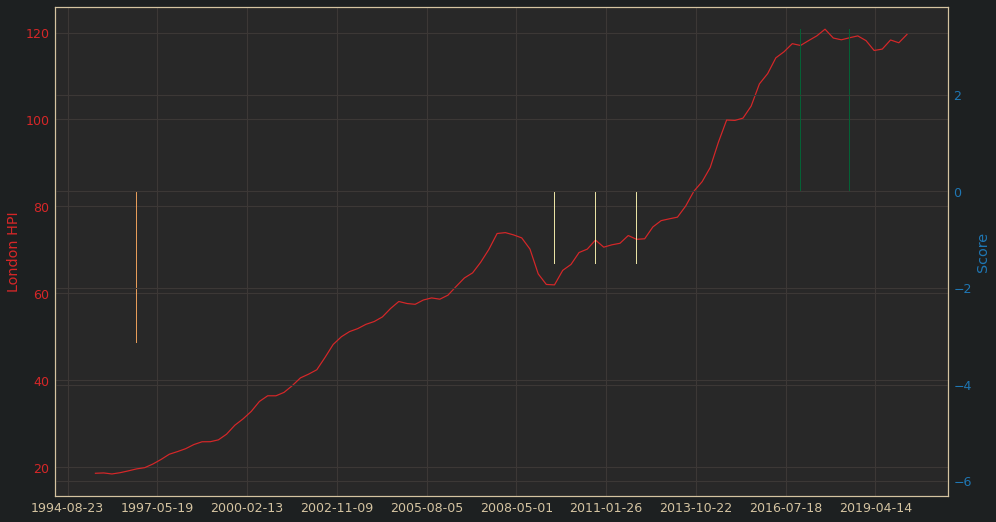

In [12]:
from matplotlib import cm

X = df[[c for c in df.columns if not c in ['London HPI']]]

ss = StandardScaler().fit_transform(X)
ss = pd.DataFrame(ss, index=X.index, columns=X.columns)

km = KMeans(n_clusters=7)
km.fit(ss)
clusters = km.predict(ss)
ss['Cluster'] = clusters

score = ss.groupby('Cluster').mean().sum(axis=1)
ss['Score'] = ss['Cluster'].apply(lambda x: score[x])
ss['London HPI'] = df['London HPI']

fig, ax1 = plt.subplots(figsize=(16,9))

color = 'tab:red'
ax1.set_ylabel('London HPI', color=color)
ax1.plot(ss['London HPI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Score', color=color)
colors = cm.RdYlGn((ss['Score'] - score.min()) / (score.max() - score.min()))
ax2.bar(ss.index, ss['Score'], alpha=0.9, color=colors)
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(plt.MaxNLocator())
plt.show()

# Exercise 6

In [17]:
import statsmodels.api as sm
import pickle
import copy

random.seed(1)
df = pd.read_csv('ura_data_withproject.csv', index_col=0)
print(df.head(), '\n')
print(df.info(), '\n')

   log_price_psf            Project Name  Area (Sqft)  Type_Condominium  \
0       7.519692     STIRLING RESIDENCES          657                 0   
1       7.290293          WHISTLER GRAND          614                 0   
2       7.670895          MARGARET VILLE          463                 0   
3       7.525101     STIRLING RESIDENCES         1346                 0   
4       7.515889  AVENUE SOUTH RESIDENCE         1109                 0   

   Relative_tenure  SaleType_Resale  SaleType_Sub Sale  Floor_number  \
0         0.914111                0                  0          23.0   
1         0.915692                0                  0          18.0   
2         0.914111                0                  0          38.0   
3         0.914111                0                  0          23.0   
4         0.915692                0                  0           8.0   

   Market Segment_OCR  Market Segment_RCR  ...  Period_2017Q4  Period_2018Q1  \
0                   0               

In [18]:
y = df['log_price_psf']
res = []
per = ['%sQ%s' % (y,q) for y in range(2017,2021) for q in range(1,5)]
per = per[:-3]
print(per)
min_obs = 1000

['2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1']


In [44]:
for start in range(0,len(per)-5+1):
    win = per[start:start+5]
    print('Working on', win[0], 'to', win[-1])
    fil = df['Period_%s' % win[0]] == 1
    for i in [1,2,3,4]:
        fil = fil | (df['Period_%s' % win[i]] ==1)
    fil = copy.deepcopy(df[fil])
    
    # Fit overall model
    print('...fitting overall')
    y = fil['log_price_psf']
    cols = [c for c in df.columns if not c.startswith('Period_') and not c in ['log_price_psf', 'Project Name']]
    X = fil[cols]
    X = sm.add_constant(X)
    
    mod = sm.OLS(y, X)
    res = mod.fit()
    res.save('temp/rolling_%s.pkl' % win[-1])
    
    # Cluster the data
    print('...clustering')
    cols = [c for c in df.columns if not c.startswith('Period_') and not c.startswith('District') and not c.startswith('Type') and not c.startswith('SaleType') and not c.startswith('Market Segment')]
    # cols_std =
    mean = fil.groupby('Project Name')[cols].mean()
    mean.columns = ['%s_mean' % c for c in mean.columns]
    std = fil.groupby('Project Name')[cols].std()
    std.columns = ['%s_std' % c for c in std.columns]
    std.fillna(0, inplace=True)
    clus = pd.concat([mean, std], axis=1)
    
    ss = StandardScaler().fit_transform(clus)
    ss = pd.DataFrame(ss, index=clus.index, columns=clus.columns)
    
    pca = PCA()
    pca.fit_transform(ss)
    red = PCA(n_components=5).fit_transform(ss)
    
    km = KMeans(n_clusters=3)
    km.fit(red)
    lab = km.predict(red)
    ss['Cluster'] = lab
    pickle.dump(ss['Cluster'], open('temp/K3_cluster_%s.pkl' % win[-1], 'wb'))
    fil['Cluster'] = fil['Project Name'].apply(lambda x: ss.loc[x, 'Cluster'])
    
    # Fit one model for each cluster
    clus_gr = fil.groupby('Cluster')
    for c, d in clus_gr:
        c = int(c)
        if len(d) < min_obs:
            print('...skipping cluster', c)
        else:
            print('...fitting cluster', c)
            y = d['log_price_psf']
            cols = [c for c in df.columns if not c.startswith('Period_') and not c in ['log_price_psf', 'Project Name']] + ['Period_%s' % p for p in per[1:5]]
            X = d[cols]
            X = sm.add_constant(X)
            
            mod = sm.OLS(y,X)
            res = mod.fit()
            res.save('temp/rolling_%s_K3_%s.pkl' % (win[-1], c))
print('\nFinished: Models saved in temp folder')

Working on 2017Q1 to 2018Q1
...fitting overall
...clustering
...fitting cluster 0
...skipping cluster 1
...fitting cluster 2
Working on 2017Q2 to 2018Q2
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2017Q3 to 2018Q3
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2017Q4 to 2018Q4
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q1 to 2019Q1
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q2 to 2019Q2
...fitting overall
...clustering
...skipping cluster 0
...fitting cluster 1
...fitting cluster 2
Working on 2018Q3 to 2019Q3
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q4 to 2019Q4
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
